# Introduction

哈罗，各位 ~ 本文对[安泰杯 —— 跨境电商智能算法大赛](https://tianchi.aliyun.com/competition/entrance/231718/introduction)数据进行了初探与可视化处理，便于各位更为直观理解赛题数据与建模目标。 

没有参加这个比赛的同学可能没有办法在天池这里下载到数据集，可以移步到这里下载：https://pan.baidu.com/s/18Z2mW8TFxwJvOWqmGXdPeg 提取码: iqrd

    
[赛题目标]：通过用户历史订单数据，预测用户下一次购买的商品。

[赛题数据]：共7个文件。

第一轮初赛共4个文件：训练数据(Antai_AE_round1_train_20190626.csv)、测试数据(Antai_AE_round1_test_20190626.csv)、商品信息(Antai_AE_round1_item_attr_20190626.csv)、提交示例(Antai_AE_round1_submit_20190715.csv)

第二轮复赛共3个文件：训练数据(Antai_AE_round2_train_20190813.csv)、测试数据(Antai_AE_round2_test_20190813.csv)、商品信息(Antai_AE_round2_item_attr_20190813.csv)

1. 训练数据：用户每次购买的商品id，订单日期以及用户国家标识

2. 测试数据：较于训练数据，测试数据剔除了模型需要预测的最后一次用户购买记录

3. 商品信息：商品id、品类id、店铺id和商品价格

4. 提交示例：预测用户购买商品Top30的item_id依概率从高到低排序，buyer_admin_id,predict 1,predict 2,…,predict 30



## 载入数据分析库包

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import gc
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f'%x)

## 读取数据

In [2]:
item = pd.read_csv('../data/Antai_AE/Antai_AE_round1_item_attr_20190626.csv')
train = pd.read_csv('../data/Antai_AE/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE/Antai_AE_round1_test_20190626.csv')
submit = pd.read_csv('../data/Antai_AE/Antai_AE_round1_submit_20190715.csv', header=None)

In [3]:
# 商品属性表:
## item_id: 商品id
## cate: 类目id
## store_id: 店铺id
## item_price: 加密价格，其中价格的加密函数f(x)为一个单调增函数
item.head()

,item_id,cate_id,store_id,item_price
0,240607,1495,12239,1
1,285232,1498,12239,1
2,113669,1503,12239,1
3,253601,1422,12239,1
4,246568,1497,12239,1


In [4]:
item.isnull().sum()

item_id       0
cate_id       0
store_id      0
item_price    0
dtype: int64

In [5]:
item["item_id"].nunique(), item["cate_id"].nunique(), item["store_id"].nunique(), item["item_price"].nunique()

(2832669, 4243, 95105, 20230)

In [6]:
# xx国的用户的购买数据和yy国的A部分用户的购买数据

# buyer_country_id: 买家国家id, 只有'xx'和'yy'两种取值
# buyer_admin_id: 买家id
# item_id: 商品id
# create_order_time: 订单创建时间
# irank: 每个买家对应的所有记录按照时间顺序的逆排序

train.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank
0,xx,8362078,1,2018-08-10 23:49:44,12
1,xx,9694304,2,2018-08-03 23:55:07,9
2,yy,101887,3,2018-08-27 08:31:26,3
3,xx,8131786,3,2018-08-31 06:00:19,9
4,xx,9778613,5,2018-08-21 06:01:56,14


In [7]:
train.isnull().sum()

buyer_country_id     0
buyer_admin_id       0
item_id              0
create_order_time    0
irank                0
dtype: int64

In [8]:
train.query("buyer_admin_id==8362078").sort_values(by="irank")

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank
9725766,xx,8362078,9859480,2018-08-28 11:39:21,1
3487488,xx,8362078,3530082,2018-08-28 11:16:46,2
4080151,xx,8362078,4130245,2018-08-27 11:49:46,3
3305675,xx,8362078,3346056,2018-08-27 11:34:43,4
7182569,xx,8362078,7275850,2018-08-27 11:28:09,5
5795425,xx,8362078,5869190,2018-08-26 04:53:48,6
5795424,xx,8362078,5869190,2018-08-26 04:53:48,7
5768184,xx,8362078,5841575,2018-08-25 11:35:33,8
6866353,xx,8362078,6955075,2018-08-18 00:53:36,9
6866354,xx,8362078,6955075,2018-08-18 00:53:36,10


In [9]:
# yy国的B部分用户的购买数据除掉最后一条
test.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank
0,yy,1061132,189045,2018-07-17 07:43:40,18
1,yy,1081430,10713670,2018-07-17 09:43:15,8
2,yy,1918135,10546322,2018-07-17 11:11:34,9
3,yy,103277,5199603,2018-07-17 13:27:44,24
4,yy,103277,2477273,2018-07-17 13:27:44,22


In [10]:
test.isnull().sum()

buyer_country_id     0
buyer_admin_id       0
item_id              0
create_order_time    0
irank                0
dtype: int64

In [11]:
# 数据集特点：
# 1）每个用户有至少7条购买数据；
# 2）测试数据中每个用户的最后一条购买数据(去掉了)所对应的商品一定在训练数据中出现过；
# 3）少量用户在两个国家有购买记录，评测中将忽略这部分记录；
train.groupby("buyer_admin_id").size().min(), test.groupby("buyer_admin_id").size().min()

(8, 7)

In [12]:
pd.concat([train, test]).groupby("buyer_admin_id")["buyer_country_id"].nunique().value_counts()

1    820503
2       102
Name: buyer_country_id, dtype: int64

In [13]:
two_country_buyers = pd.concat([train, test]).groupby("buyer_admin_id")["buyer_country_id"].nunique()\
    .reset_index().query("buyer_country_id==2")["buyer_admin_id"].tolist()

test_buyers = test["buyer_admin_id"].unique().tolist()
for b in two_country_buyers:
    if b in test_buyers:
        print(b)

3106927
12368445
12647969
12858772
12929117
13000419


In [14]:
submit.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,152,343131,2140290,2600629,1554159,12211445,776612,1630164,3901301,8353580,...,2327622,2014295,5076158,5042708,818444,10451831,4333367,9437487,8469786,9465790
1,282,8988184,2210260,96479,4052816,7982989,11143899,10070236,2002400,8757854,...,5630838,8607737,7740462,7028968,9167824,12938507,6399956,3109441,10636176,6255625
2,321,11140901,4618502,9666424,421308,8443514,12341414,4133929,4374880,9104983,...,12975999,10793761,7524523,666863,204808,8893340,7431033,1773069,12970909,9373627
3,809,692592,9851186,5206030,1210732,6016462,6971778,11615323,7263674,10901782,...,3227122,10539551,2802000,8251066,9515496,7065316,11997137,4438427,6567724,7212577
4,870,8361014,2327622,5481981,7530272,11680535,6555249,6137574,914424,10445923,...,8757854,10578287,10715090,7176446,3165153,10144005,8753413,2800387,12152573,1068526


In [15]:
submit.shape, test["buyer_admin_id"].nunique()

((11398, 31), 11398)

### 数据预处理
* 合并train和test文件
* 提取日期年月日等信息
* 关联商品价格、品类、店铺
* 转化每列数据类型为可存储的最小值，减少内存消耗
* 保存为hdf5格式文件，加速读取

In [16]:
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])

df['create_order_time'] = pd.to_datetime(df['create_order_time'])
df['date'] = df['create_order_time'].dt.date
df['day'] = df['create_order_time'].dt.day
df['hour'] = df['create_order_time'].dt.hour

df = pd.merge(df, item, how='left', on='item_id')

In [17]:
df.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,8362078,1,2018-08-10 23:49:44,12,1,2018-08-10,10,23,2324.00,10013.00,4501.00
1,xx,9694304,2,2018-08-03 23:55:07,9,1,2018-08-03,3,23,3882.00,4485.00,2751.00
2,yy,101887,3,2018-08-27 08:31:26,3,1,2018-08-27,27,8,155.00,8341.00,656.00
3,xx,8131786,3,2018-08-31 06:00:19,9,1,2018-08-31,31,6,155.00,8341.00,656.00
4,xx,9778613,5,2018-08-21 06:01:56,14,1,2018-08-21,21,6,1191.00,1949.00,1689.00


In [18]:
memory = df.memory_usage().sum() / 1024**2 
print('Before memory usage of properties dataframe is :', memory, " MB")

dtype_dict = {'buyer_admin_id' : 'int32', 
              'item_id' : 'int32', 
              'store_id' : pd.Int32Dtype(),
              'irank' : 'int16',
              'item_price' : pd.Int16Dtype(),
              'cate_id' : pd.Int16Dtype(),
              'is_train' : 'int8',
              'day' : 'int8',
              'hour' : 'int8',
              'buyer_country_id': str,
              'date': str
             }

df = df.astype(dtype_dict)
memory = df.memory_usage().sum() / 1024**2 
print('After memory usage of properties dataframe is :', memory, " MB")
del train, test; 

Before memory usage of properties dataframe is : 1292.8728713989258  MB
After memory usage of properties dataframe is : 696.1623153686523  MB


In [19]:
df.isnull().any()

buyer_country_id     False
buyer_admin_id       False
item_id              False
create_order_time    False
irank                False
is_train             False
date                 False
day                  False
hour                 False
cate_id               True
store_id              True
item_price            True
dtype: bool

In [20]:
df[['store_id', 'item_price', 'cate_id']].min()

store_id      1
item_price    1
cate_id       1
dtype: int32

In [21]:
for col in ['store_id', 'item_price', 'cate_id']:
    df[col] = df[col].fillna(0).astype(np.int32).replace(0, np.nan)
df.to_hdf('../data/train_test.h5', key='df', mode='w')

In [22]:
%%time
df = pd.read_hdf('../data/train_test.h5', key='df')

CPU times: user 2.68 s, sys: 1.37 s, total: 4.04 s
Wall time: 4.04 s


In [23]:
%%time
train = pd.read_csv('../data/Antai_AE/Antai_AE_round1_train_20190626.csv')
test = pd.read_csv('../data/Antai_AE/Antai_AE_round1_test_20190626.csv')
item = pd.read_csv('../data/Antai_AE/Antai_AE_round1_item_attr_20190626.csv')
del train, test;

CPU times: user 8.12 s, sys: 1.23 s, total: 9.35 s
Wall time: 9.37 s


# Overview: 数据内容

In [24]:
df.head()

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,8362078,1,2018-08-10 23:49:44,12,1,2018-08-10,10,23,2324.00,10013.00,4501.00
1,xx,9694304,2,2018-08-03 23:55:07,9,1,2018-08-03,3,23,3882.00,4485.00,2751.00
2,yy,101887,3,2018-08-27 08:31:26,3,1,2018-08-27,27,8,155.00,8341.00,656.00
3,xx,8131786,3,2018-08-31 06:00:19,9,1,2018-08-31,31,6,155.00,8341.00,656.00
4,xx,9778613,5,2018-08-21 06:01:56,14,1,2018-08-21,21,6,1191.00,1949.00,1689.00


In [25]:
# Null 空值统计
for pdf in [df, item]:
    for col in pdf.columns:
        print(col, pdf[col].isnull().sum())

buyer_country_id 0
buyer_admin_id 0
item_id 0
create_order_time 0
irank 0
is_train 0
date 0
day 0
hour 0
cate_id 26119
store_id 26119
item_price 26119
item_id 0
cate_id 0
store_id 0
item_price 0


In [26]:
df.describe()

,buyer_admin_id,item_id,irank,is_train,day,hour,cate_id,store_id,item_price
count,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13035341.00,13009222.00,13009222.00,13009222.00
mean,6527293.86,6522519.78,143.62,0.99,18.62,9.06,1498.53,40575.67,1099.75
std,3764280.24,3765432.09,1573.84,0.11,9.21,6.56,903.26,24284.46,2880.00
min,1.00,1.00,-32768.00,0.00,1.00,0.00,1.00,1.00,1.00
25%,3269515.00,3261386.00,4.00,1.00,10.00,4.00,616.00,20648.00,123.00
50%,6528429.00,6522878.00,8.00,1.00,19.00,8.00,1505.00,39368.00,246.00
75%,9787265.00,9784900.00,16.00,1.00,27.00,13.00,2010.00,59273.00,700.00
max,13046721.00,13046734.00,32767.00,1.00,31.00,23.00,4243.00,95105.00,20230.00


In [27]:
item.describe()

,item_id,cate_id,store_id,item_price
count,2832669.00,2832669.00,2832669.00,2832669.00
mean,6429138.00,1481.10,40256.46,1124.00
std,3725431.44,923.09,24370.92,2110.62
min,1.00,1.00,1.00,1.00
25%,3224114.00,600.00,19850.00,180.00
50%,6391845.00,1499.00,38954.00,400.00
75%,9636216.00,2050.00,58406.00,1200.00
max,13046734.00,4243.00,95105.00,20230.00


数据内容：
* 用户、商品、店铺、品类乃至商品价格都是从1开始用整数编号
* 订单日期格式为：YYYY-mm-dd HH:mm:ss
* 源数据中都木有空值，但是由于某些商品，不在商品表，因此缺少了一些价格、品类信息。

# 数据探查

## 训练集与测试集

In [28]:
train = df['is_train']==1
test = df['is_train']==0

In [29]:
train_count = len(df[train])
print('训练集样本量是',train_count)
test_count = len(df[test])
print('测试集样本量是',test_count)
print('样本比例为：', train_count/test_count)

训练集样本量是 12868509
测试集样本量是 166832
样本比例为： 77.13453653975256


### buyer_country_id 国家编号

In [30]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'buyer_country_id'] + col
    
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'buyer_country_id']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer').sort_values(by=['count'], ascending=False)

In [31]:
groupby_cnt_ratio(df, [])

count  count_ratio
is_train buyer_country_id                       
1        xx                10635642         1.00
         yy                 2232867         1.00
0        yy                  166832         1.00

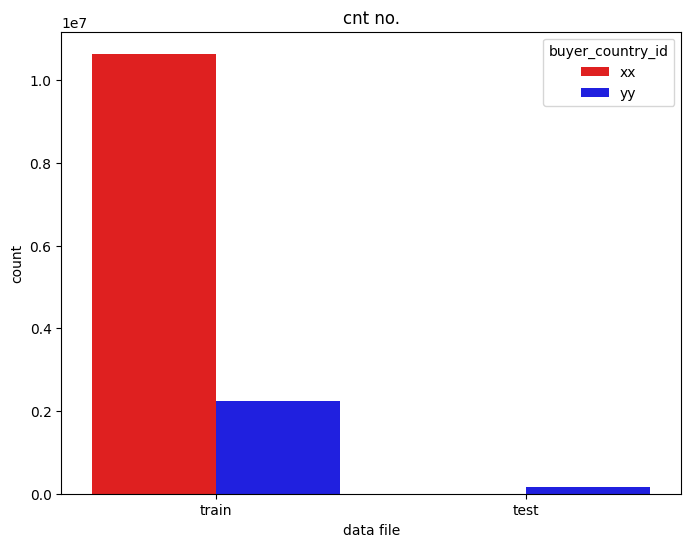

In [32]:
plt.figure(figsize=(8,6))
sns.countplot(x='is_train', data = df, palette=['red', 'blue'], hue='buyer_country_id', order=[1, 0])
plt.xticks(np.arange(2), ('train', 'test'))
plt.xlabel('data file')
plt.title('cnt no.');

buyer_country_id 国家编号

> 本次比赛给出若干日内来自成熟国家的部分用户的行为数据，以及来自待成熟国家的A部分用户的行为数据，以及待成熟国家的B部分用户的行为数据去除每个用户的最后一条购买数据，让参赛人预测B部分用户的最后一条行为数据。

* 训练集中有2个国家数据，xx国家样本数10635642，占比83%，yy国家样本数2232867条，仅占17%
* 测试集中有yy国家的数据为166832条, 训练集中yy国样本数量是测试集中的13倍，如赛题目的所言，期望通过大量成熟国家来预测少量待成熟国家的用户购买行为

### buyer_admin_id 用户编号

In [33]:
print('训练集中用户数量',len(df[train]['buyer_admin_id'].unique()))
print('测试集中用户数量',len(df[test]['buyer_admin_id'].unique()))

训练集中用户数量 809213
测试集中用户数量 11398


In [34]:
union = list(set(df[train]['buyer_admin_id'].unique()).intersection(set(df[test]['buyer_admin_id'].unique())))
print('同时在训练集测试集出现的有6位用户，id如下：', union)

同时在训练集测试集出现的有6位用户，id如下： [12647969, 13000419, 3106927, 12858772, 12929117, 12368445]


In [35]:
df[train].query(f"buyer_admin_id in {tuple(union)}").sort_values(by=['buyer_admin_id','irank']).head(10)

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
7546704,xx,3106927,7645546,2018-08-30 02:49:22,1,1,2018-08-30,30,2,1164.00,73781.00,770.00
4582539,xx,3106927,4639151,2018-08-30 02:49:22,2,1,2018-08-30,30,2,2214.00,53190.00,1669.00
11953258,xx,3106927,12122118,2018-08-30 02:49:22,3,1,2018-08-30,30,2,236.00,73781.00,884.00
255625,xx,3106927,258860,2018-08-30 02:49:22,4,1,2018-08-30,30,2,189.00,24221.00,900.00
7402817,xx,3106927,7499372,2018-08-30 02:49:22,5,1,2018-08-30,30,2,2214.00,32535.00,2714.00
9483312,xx,3106927,9613063,2018-08-30 02:49:22,6,1,2018-08-30,30,2,3069.00,73781.00,110.00
2740080,xx,3106927,2773189,2018-08-27 08:18:23,10,1,2018-08-27,27,8,1865.00,49499.00,20067.00
12152249,xx,3106927,12324030,2018-08-27 07:15:05,11,1,2018-08-27,27,7,880.00,92968.00,1764.00
2201292,xx,3106927,2227720,2018-08-19 02:36:36,12,1,2018-08-19,19,2,1164.00,6404.00,1900.00
6717641,xx,3106927,6804187,2018-08-19 02:33:39,13,1,2018-08-19,19,2,1164.00,52421.00,230.00


In [36]:
df[test].query(f"buyer_admin_id in {tuple(union)}").sort_values(by=['buyer_admin_id','irank']).head(3)

,buyer_country_id,buyer_admin_id,item_id,create_order_time,irank,is_train,date,day,hour,cate_id,store_id,item_price
13016145,yy,3106927,202354,2018-08-30 02:48:40,7,0,2018-08-30,30,2,642.00,24221.00,989.00
13008981,yy,3106927,6994414,2018-08-29 05:48:06,8,0,2018-08-29,29,5,7.00,37411.00,1521.00
13008982,yy,3106927,6994414,2018-08-29 05:48:06,9,0,2018-08-29,29,5,7.00,37411.00,1521.00


#### 用户记录数分布

In [37]:
admin_cnt = groupby_cnt_ratio(df, 'buyer_admin_id')
admin_cnt.groupby(['is_train','buyer_country_id']).head(3)

count  count_ratio
is_train buyer_country_id buyer_admin_id                    
1        xx               10828801        42751         0.00
                          10951390        23569         0.00
                          11223615        19933         0.00
         yy               2381782          3480         0.00
                          2333316          1944         0.00
                          2365356          1686         0.00
0        yy               2041038          1386         0.01
                          2070430           399         0.00
                          1144848           286         0.00

In [38]:
# 用户购买记录数——最多、最少、中位数
admin_cnt.groupby(['is_train','buyer_country_id'])['count'].agg(['max','min','median'])

max  min  median
is_train buyer_country_id                    
0        yy                 1386    7   11.00
1        xx                42751    8   11.00
         yy                 3480    8   12.00

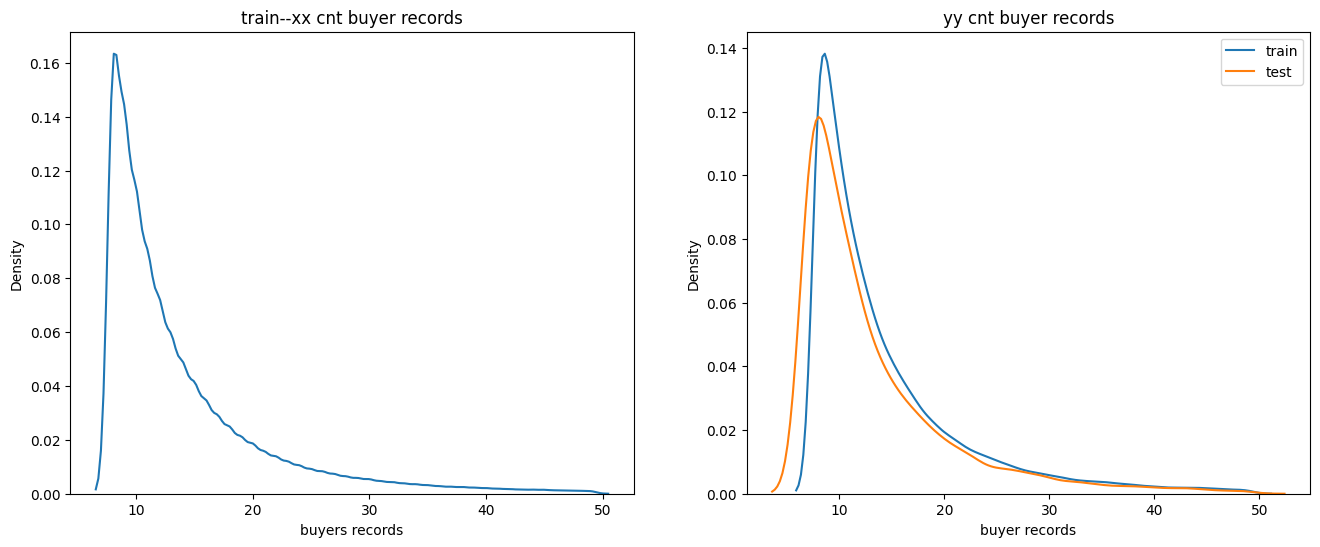

In [39]:
fig, ax = plt.subplots(1, 2 ,figsize=(16,6))
ax[0].set(xlabel='buyers records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==1 and buyer_country_id=='xx'")['count'].values, ax=ax[0])\
    .set_title('train--xx cnt buyer records')

ax[1].set(xlabel='buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==1 and buyer_country_id=='yy'")['count'].values, ax=ax[1])\
    .set_title('yy cnt buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==0 and buyer_country_id=='yy'")['count'].values, ax=ax[1])
ax[1].legend(labels=['train', 'test'], loc="upper right")

In [40]:
admin_cnt.columns = ['records', 'ratio']
admin_user_cnt = groupby_cnt_ratio(admin_cnt, 'records')
admin_user_cnt.columns = ['buyers', 'buyers_ratio']
admin_user_cnt.head()

buyers  buyers_ratio
is_train buyer_country_id records                      
1        xx               8        118155          0.18
                          9         91757          0.14
                          10        72936          0.11
                          11        57678          0.09
                          12        46534          0.07

In [41]:
# xx cnt 
admin_user_cnt.reset_index().set_index("records").query("is_train==1 and buyer_country_id=='xx'")[['buyers','buyers_ratio']].T

records,8,9,10,11,12,13,14,15,16,17,...,521,556,526,528,529,537,545,549,550,554
buyers,118155.00,91757.00,72936.00,57678.00,46534.00,38114.00,31432.00,26735.00,22352.00,18742.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
buyers_ratio,0.18,0.14,0.11,0.09,0.07,0.06,0.05,0.04,0.03,0.03,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [42]:
# yy cnt
admin_user_cnt.loc[([1,0],'yy',slice(None))].unstack(0).head(10)

buyers          buyers_ratio     
is_train                       0        1            0    1
buyer_country_id records                                   
yy               8       1453.00 22535.00         0.13 0.16
                 9       1194.00 17964.00         0.10 0.13
                 10       986.00 14458.00         0.09 0.10
                 11       894.00 11666.00         0.08 0.08
                 12       655.00  9688.00         0.06 0.07
                 13       549.00  7988.00         0.05 0.06
                 14       447.00  6569.00         0.04 0.05
                 15       399.00  5630.00         0.04 0.04
                 16       326.00  4834.00         0.03 0.03
                 17       306.00  4162.00         0.03 0.03

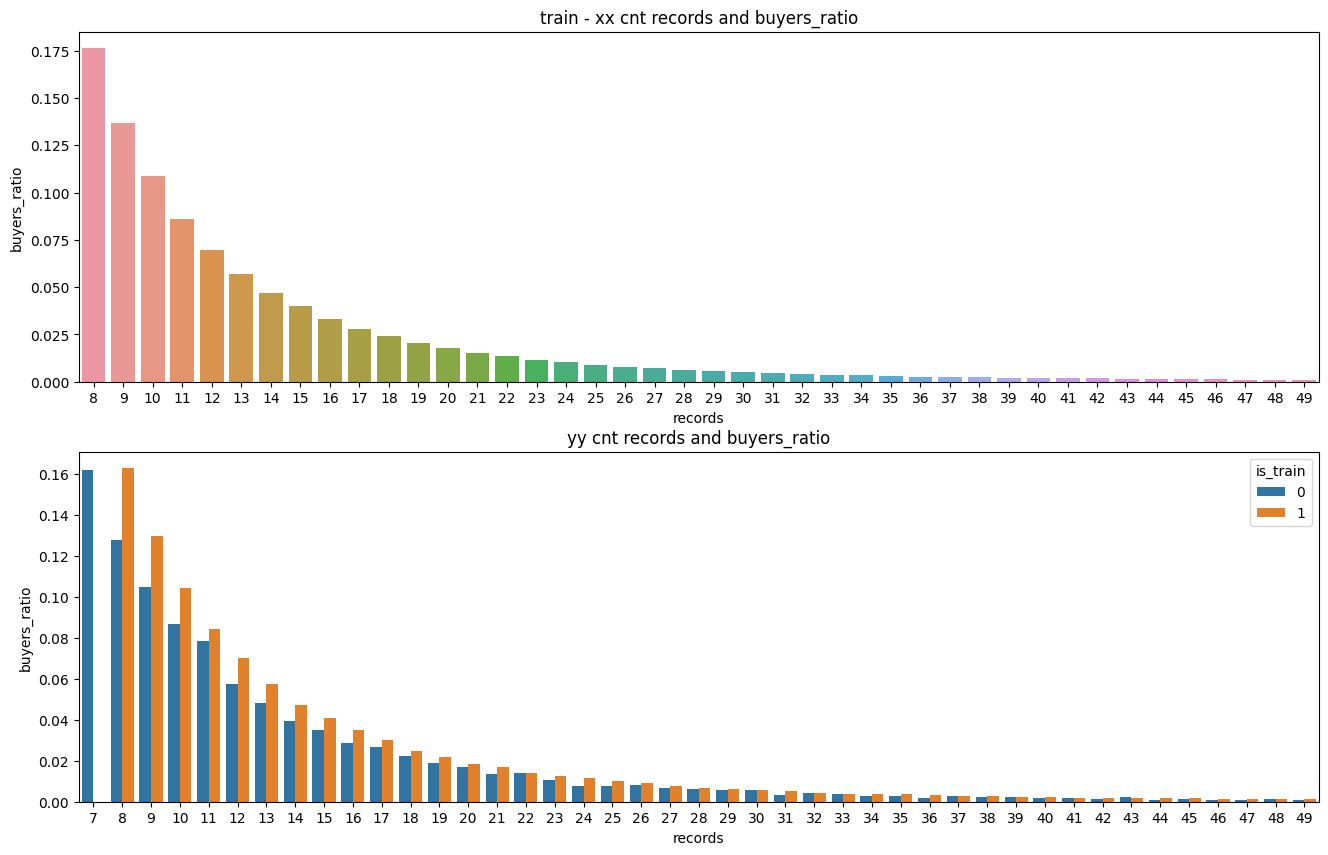

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
admin_plot = admin_user_cnt.reset_index()
sns.barplot(x='records', y='buyers_ratio', data=admin_plot[(admin_plot['records']<50) & (admin_plot['buyer_country_id']=='xx')], 
            estimator=np.mean, ax=ax[0]).set_title('train - xx cnt records and buyers_ratio');

sns.barplot(x='records', y='buyers_ratio', hue='is_train', data=admin_plot[(admin_plot['records']<50) & (admin_plot['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy cnt records and buyers_ratio');

用户记录数进一步探查结论：
    * 不管是训练集还是验证集，99%的用户购买记录都在50条内，这是比较符合正常逻辑
    * TODO:对于发生大量购买行为的用户，后面再单独探查，是否有其他规律或疑似刷单现象

### item_id 商品编号

In [44]:
print('商品表中商品数：',len(item['item_id'].unique()))
print('训练集中商品数：',len(df[train]['item_id'].unique()))
print('测试集中商品数：',len(df[test]['item_id'].unique()))
print('仅训练集有的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(df[test]['item_id'].unique())))))
print('仅测试集有的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(df[train]['item_id'].unique())))))
print('训练集测试集共同商品数：',len(list(set(df[train]['item_id'].unique()).intersection(set(df[test]['item_id'].unique())))))
print('训练集中不在商品表的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(item['item_id'].unique())))))
print('测试集中不在商品表的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(item['item_id'].unique())))))

商品表中商品数： 2832669
训练集中商品数： 2812048
测试集中商品数： 104735
仅训练集有的商品数： 2735801
仅测试集有的商品数： 28488
训练集测试集共同商品数： 76247
训练集中不在商品表的商品数： 7733
测试集中不在商品表的商品数： 313


#### 商品销量

In [77]:
item_cnt = groupby_cnt_ratio(df, 'item_id')
item_cnt.columns=['sales', 'sales_ratio']
item_cnt.reset_index(inplace=True)
item_cnt

,is_train,buyer_country_id,item_id,sales,sales_ratio
0,1,xx,12691565,112659,0.01
1,1,xx,12824199,35979,0.00
2,1,xx,12673275,14668,0.00
3,1,xx,12891086,12335,0.00
4,1,xx,634028,7900,0.00
...,...,...,...,...,...
3325862,1,xx,3037632,1,0.00
3325863,1,xx,9845407,1,0.00
3325864,1,xx,9845405,1,0.00
3325865,1,xx,3037633,1,0.00


In [78]:
top_item_plot = item_cnt.groupby(['is_train','buyer_country_id']).head(10)
top_item_plot

,is_train,buyer_country_id,item_id,sales,sales_ratio
0,1,xx,12691565,112659,0.01
1,1,xx,12824199,35979,0.00
2,1,xx,12673275,14668,0.00
3,1,xx,12891086,12335,0.00
4,1,xx,634028,7900,0.00
5,1,xx,10266898,6079,0.00
6,1,xx,10027998,5539,0.00
7,1,xx,12049470,5357,0.00
8,1,xx,12817558,4915,0.00
9,1,xx,1359800,4708,0.00


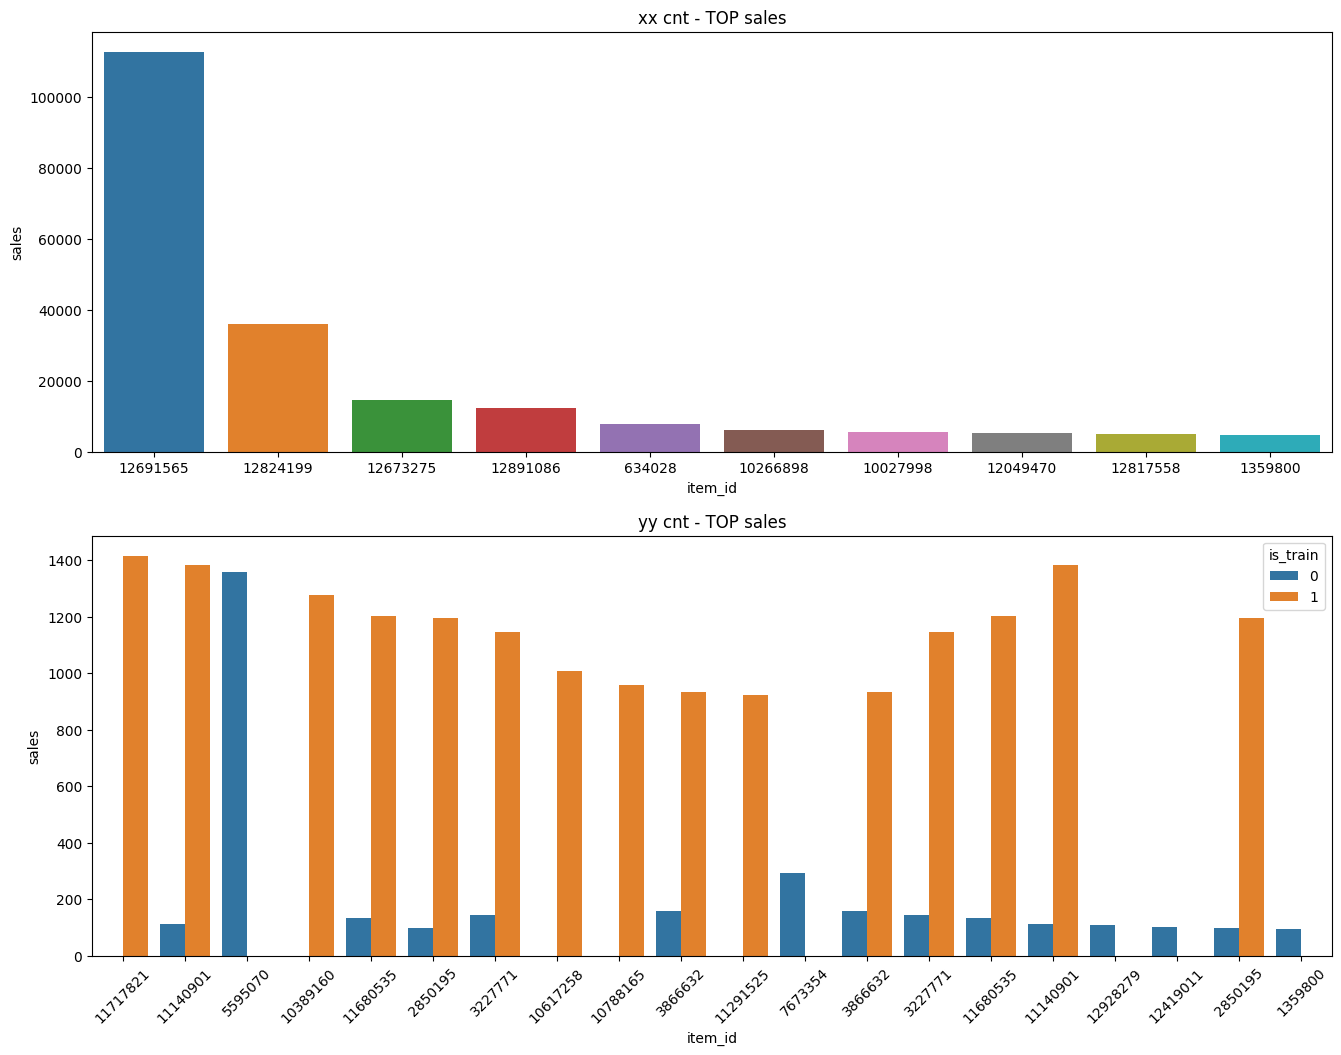

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(16,12))
sns.barplot(x='item_id', y='sales', data=top_item_plot[top_item_plot['buyer_country_id']=='xx'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='xx'], ax=ax[0], estimator=np.mean).set_title('xx cnt - TOP sales')
sns.barplot(x='item_id', y='sales', hue='is_train', data=top_item_plot[top_item_plot['buyer_country_id']=='yy'], 
            order=top_item_plot['item_id'][top_item_plot['buyer_country_id']=='yy'], ax=ax[1], estimator=np.mean).set_title('yy cnt - TOP sales')
_ = plt.xticks(rotation=45)

#### 整体商品销量分布

In [85]:
item_order_cnt = groupby_cnt_ratio(item_cnt, 'sales')
item_order_cnt.columns = ['sales_count', 'sales_count_ratio']
item_order_cnt

sales_count  sales_count_ratio
is_train buyer_country_id sales                                
1        xx               1          1331056               0.58
         yy               1           625041               0.67
         xx               2           361829               0.16
                          3           164953               0.07
         yy               2           139607               0.15
...                                      ...                ...
         xx               1245             1               0.00
                          1248             1               0.00
                          1276             1               0.00
                          1279             1               0.00
         yy               1415             1               0.00

[1453 rows x 2 columns]

In [86]:
item_order_cnt.groupby(['is_train','buyer_country_id']).head(5).sort_values(by=['buyer_country_id','is_train'])

sales_count  sales_count_ratio
is_train buyer_country_id sales                                
1        xx               1          1331056               0.58
                          2           361829               0.16
                          3           164953               0.07
                          4            95629               0.04
                          5            61551               0.03
0        yy               1            81212               0.78
                          2            13083               0.12
                          3             4350               0.04
                          4             2123               0.02
                          5             1200               0.01
1        yy               1           625041               0.67
                          2           139607               0.15
                          3            55274               0.06
                          4            29848               0.03
                          5            17782               0.02

In [87]:
item_order_plot = item_order_cnt.reset_index()
item_order_plot = item_order_plot[item_order_plot['sales']<=8]

xx_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='xx']
yy_item_order_plot = item_order_plot[item_order_plot['buyer_country_id']=='yy']
yy_item_order_plot_1 = yy_item_order_plot[yy_item_order_plot['is_train']==1]
yy_item_order_plot_0 = yy_item_order_plot[yy_item_order_plot['is_train']==0]

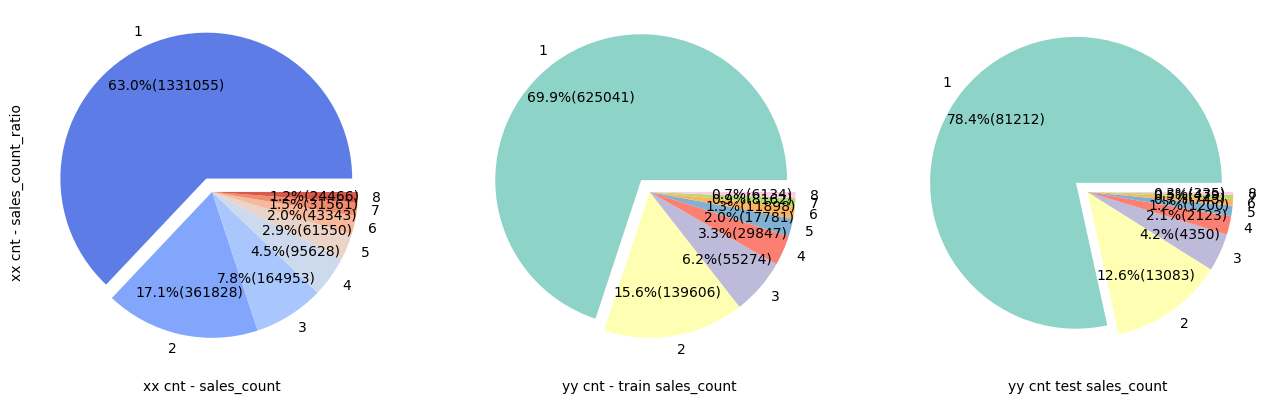

In [88]:
# 商品销量饼图
def text_style_func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, color_palette):
    return ax.pie(df['sales_count_ratio'].values, autopct=lambda pct: text_style_func(pct, df['sales_count']), labels = df['sales'], 
                  explode = [0.1]+ np.zeros(len(df)-1).tolist(), pctdistance = 0.7, colors=sns.color_palette(color_palette, 8))

fig, ax = plt.subplots(1, 3, figsize=(16,12))
ax[0].set(xlabel='xx cnt - sales_count')
ax[0].set(ylabel='xx cnt - sales_count_ratio')
pie_param(ax[0], xx_item_order_plot, "coolwarm")
ax[1].set(xlabel='yy cnt - train sales_count')
pie_param(ax[1], yy_item_order_plot_1, "Set3")
ax[2].set(xlabel='yy cnt test sales_count')
pie_param(ax[2], yy_item_order_plot_0, "Set3");

In [89]:
print(xx_item_order_plot.head(10)['sales_count_ratio'].sum())
print(yy_item_order_plot_1.head(10)['sales_count_ratio'].sum())
print(yy_item_order_plot_0.head(10)['sales_count_ratio'].sum())

0.9215598591503256
0.9643666018897873
0.9884661288012603


总体来看，由于训练集数据远多于测试集数据：
* 训练集商品销量大于测试集商品销量
* 长尾趋势严重，热门商品少，大量商品仅有数次销售记录，1单商品占了绝大部分(均超过50%)
* 训练集中92%的商品销量不超过10件，而在测试集中97%的商品销量不超过10件
* 此外训练集中yy国的商品销量略大于测试集

### cate_id 品类编号

In [90]:
print('商品品类数', len(item['cate_id'].unique()))
print('训练集商品品类数', len(df[train]['cate_id'].unique()))
print('测试集商品品类数', len(df[test]['cate_id'].unique()))

商品品类数 4243
训练集商品品类数 4239
测试集商品品类数 2727


#### 各个品类下商品数量

In [91]:
cate_cnt = item.groupby(['cate_id']).size().to_frame('count').reset_index()
cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,cate_id,count
578,579,170074
2395,2396,44467
1497,1498,42676
599,600,39729
1591,1592,34820


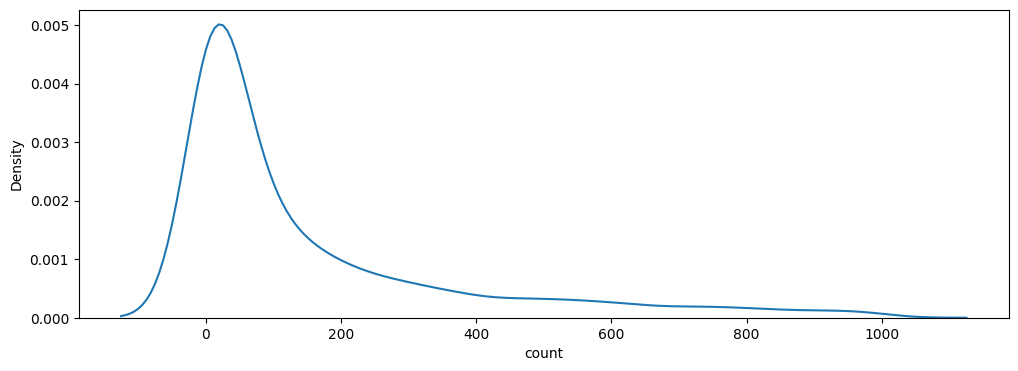

In [92]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=cate_cnt[cate_cnt['count']<1000]['count']);

### store_id 店铺编号

In [93]:
print('商品店铺数', len(item['store_id'].unique()))
print('训练集店铺数', len(df[train]['store_id'].unique()))
print('测试集店铺数', len(df[train]['store_id'].unique()))

商品店铺数 95105
训练集店铺数 94970
测试集店铺数 94970


#### 店铺下品类数量

In [94]:
store_cate_cnt = item.groupby(['store_id'])['cate_id'].nunique().to_frame('count').reset_index()
store_cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,326
45594,45595,280
44983,44984,274
1870,1871,258
22034,22035,241


In [95]:
store_cnt_cate_cnt = store_cate_cnt.groupby(['count']).size().reset_index()
store_cnt_cate_cnt.columns = ['store_cate_count', 'cate_count_store_count']

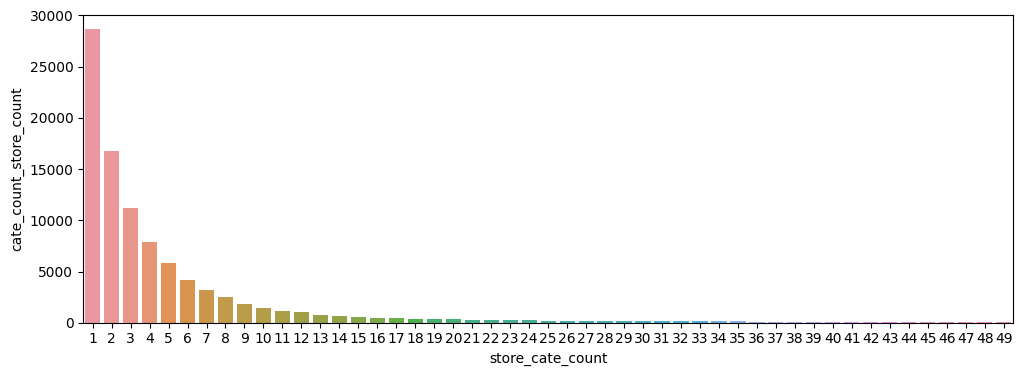

In [96]:
plt.figure(figsize=(12,4))
sns.barplot(x='store_cate_count', y='cate_count_store_count', data=store_cnt_cate_cnt[store_cnt_cate_cnt['store_cate_count']<50], estimator=np.mean);

#### 店铺下商品数量

In [97]:
store_item_cnt = item.groupby(['store_id'])['item_id'].nunique().to_frame('count').reset_index()
store_item_cnt.sort_values(by=['count'], ascending=False).head(5)

,store_id,count
0,1,6911
68671,68672,2435
33381,33382,2220
17544,17545,2053
82146,82147,2016


In [98]:
store_cnt_item_cnt = store_item_cnt.groupby(['count']).size().reset_index()
store_cnt_item_cnt.columns = ['store_item_count', 'item_count_store_count']

In [99]:
store_cnt_item_cnt.T

,0,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
store_item_count,1,2,3,4,5,6,7,8,9,10,...,1556,1558,1642,1820,1997,2016,2053,2220,2435,6911
item_count_store_count,9129,6897,5593,4879,4206,3698,3374,3050,2773,2486,...,1,1,1,1,1,1,1,1,1,1


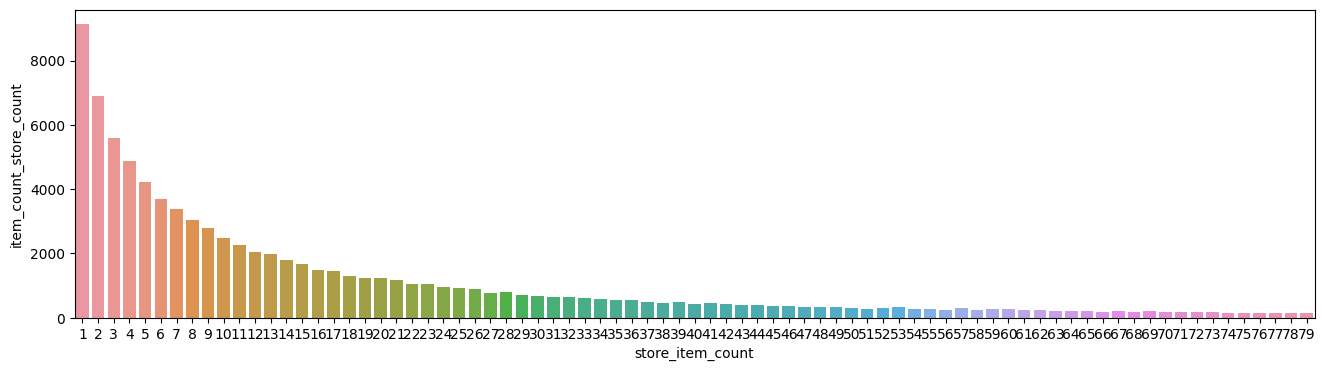

In [100]:
plt.figure(figsize=(16,4))
sns.barplot(x='store_item_count', y='item_count_store_count', data=store_cnt_item_cnt[store_cnt_item_cnt['store_item_count']<80], estimator=np.mean);

#### item_price 商品价格

In [101]:
print(item['item_price'].max(), item['item_price'].min(), item['item_price'].mean(), item['item_price'].median())

20230 1 1124.0030755446542 400.0


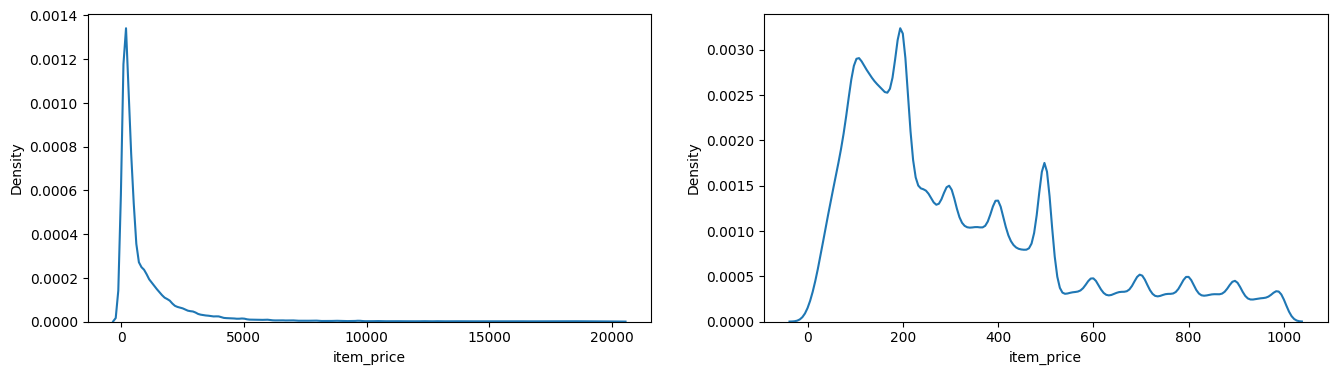

In [102]:
plt.figure(figsize=(16,4))
plt.subplot(121)
sns.kdeplot(item['item_price'])
plt.subplot(122)
sns.kdeplot(item['item_price'][item['item_price']<1000]);

In [103]:
price_cnt = item.groupby(['item_price']).size().to_frame('count').reset_index()
price_cnt.sort_values(by=['count'], ascending=False).head(10)

,item_price,count
199,200,75872
499,500,61283
99,100,33826
399,400,27670
299,300,26044
198,199,18032
999,1000,16739
699,700,12028
100,101,11972
120,121,11833


关于商品价格：商品价格是通过函数转化成了从1开始的整数，最大值为20230，最小值为1。
    * 经常对商品价格统计，大部分商品都是整百数，Top5价格200\500\100\400\300
    * TODO：整百商品探查

#### 有售商品价格

In [104]:
print(df[train]['item_price'].max(), df[train]['item_price'].min(), df[train]['item_price'].mean(), df[train]['item_price'].median())
print(df[test]['item_price'].max(), df[test]['item_price'].min(), df[test]['item_price'].mean(), df[test]['item_price'].median())

20230.0 1.0 1103.9060915681803 245.0
19907.0 1.0 778.7395852140734 270.0


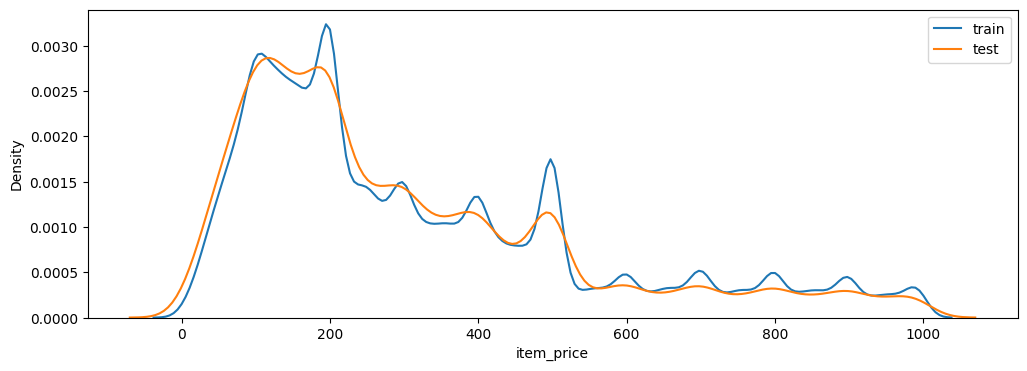

In [107]:
plt.figure(figsize=(12,4))
sns.kdeplot(df[train][df[train]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price'])
sns.kdeplot(df[test][df[test]['item_price']<1000][['item_id','item_price']].drop_duplicates()['item_price'])
_ = plt.legend(["train","test"])

商品价格与销量

In [108]:
df[train].groupby(['item_price'])['item_id'].nunique().to_frame('same_price_items').head()

,same_price_items
item_price,
1.00,266
2.00,1305
3.00,204
4.00,152
5.00,133


In [109]:
price_cnt = groupby_cnt_ratio(df, 'item_price')
price_cnt.groupby(['is_train', 'buyer_country_id']).head(5)

count  count_ratio
is_train buyer_country_id item_price                     
1        xx               200.00      404366         0.04
                          500.00      201061         0.02
                          100.00      186473         0.02
                          17844.00    114631         0.01
                          121.00       92956         0.01
         yy               200.00       82625         0.04
                          500.00       48651         0.02
                          100.00       38838         0.02
                          300.00       27452         0.01
                          400.00       24144         0.01
0        yy               200.00        6846         0.04
                          500.00        3582         0.02
                          100.00        3019         0.02
                          300.00        2084         0.01
                          400.00        1765         0.01

似乎价格与销量并无直接关系
    * 但是价格为100、200、300、400、500整百数位居销量榜
    * xx国，17844如此高价格的商品销量这么高？

### create_order_time 订单日期

In [110]:
print(df[train]['create_order_time'].min(), df[train]['create_order_time'].max())
print(df[test]['create_order_time'].min(), df[test]['create_order_time'].max())

2018-07-13 05:54:54 2018-08-31 23:59:57
2018-07-17 07:43:40 2018-08-31 23:58:56


In [111]:
train_df_seven = df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]
train_df_eight = df[train][df[train]['create_order_time']>=pd.to_datetime('2018-08-01')]

In [112]:
print('7月数据量',len(df[train][df[train]['create_order_time']<pd.to_datetime('2018-08-01')]),
      '\n8月数据量',len(df[train][df[train]['create_order_time']>=pd.to_datetime('2018-08-01')]))

7月数据量 17856 
8月数据量 12850653


In [74]:
date_cnt = groupby_cnt_ratio(df, 'date')
# date_cnt.columns = ['当天销量', "占比"]
# date_cnt = date_cnt.reset_index()

/Users/mac/.local/share/virtualenvs/AntaiCup-vTCStMaD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 24403 (\N{CJK UNIFIED IDEOGRAPH-5F53}) missing from current font.
  func(*args, **kwargs)
/Users/mac/.local/share/virtualenvs/AntaiCup-vTCStMaD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  func(*args, **kwargs)
/Users/mac/.local/share/virtualenvs/AntaiCup-vTCStMaD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 38144 (\N{CJK UNIFIED IDEOGRAPH-9500}) missing from current font.
  func(*args, **kwargs)
/Users/mac/.local/share/virtualenvs/AntaiCup-vTCStMaD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  func(*args, **kwargs)
/Users/mac/.local/share/virtualenvs/AntaiCup-vTCStMaD/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 

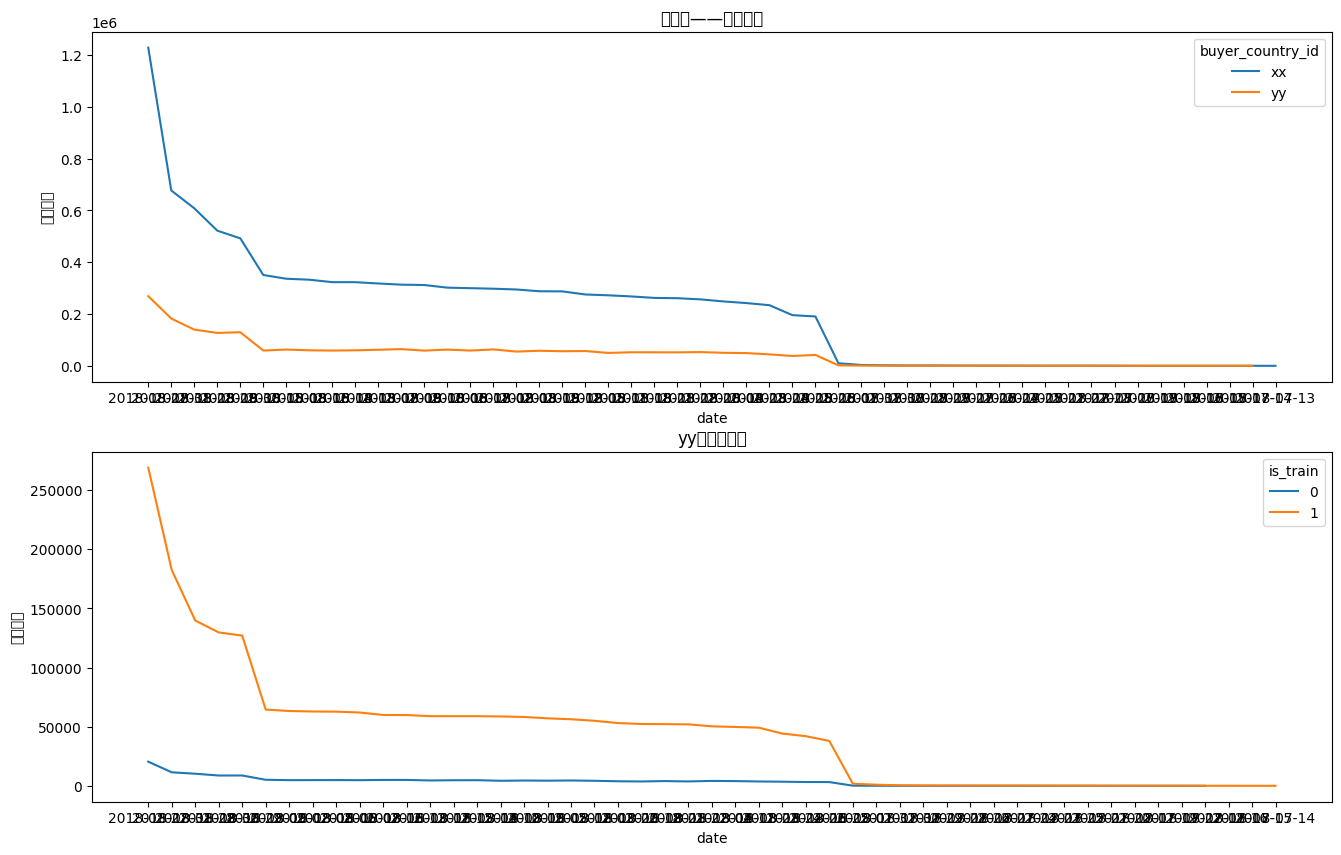

In [75]:
fig, ax = plt.subplots(2, 1, figsize=(16,10))
sns.lineplot(x='date', y='当天销量', hue='buyer_country_id', data=date_cnt[(date_cnt['is_train']==1)], 
            estimator=np.mean, ax=ax[0]).set_title('训练集——每日销量');

sns.lineplot(x='date', y='当天销量', hue='is_train', data=date_cnt[(date_cnt['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('yy国每日销量');

很明显：
* 训练集中7月份数据远小于8月份数据
* 训练集中xx国和yy国每日销量趋势十分相似，且在27日有个波峰

In [76]:
seven = date_cnt[date_cnt['date']<pd.to_datetime('2018-08-02')]
eight = date_cnt[date_cnt['date']>=pd.to_datetime('2018-08-02')]

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20,16))
def barplot(ax, df, title):
    df['date'] = df['date'].astype(str)
    sns.barplot(y='date', x='当天销量' ,data=df, order=sorted(df['date'].unique()), ax=ax, estimator=np.mean)\
    .set_title(title)
    
barplot(ax[0][0], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='xx')], 'xx国7月份销量')
barplot(ax[1][0], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='xx')], 'xx国8月份销量')
barplot(ax[0][1], seven[(seven['is_train']==1) & (seven['buyer_country_id']=='yy')], '训练集-yy国7月份销量')
barplot(ax[1][1], eight[(eight['is_train']==1) & (eight['buyer_country_id']=='yy')], '训练集-yy国8月份销量')
barplot(ax[0][2], seven[(seven['is_train']==0) & (seven['buyer_country_id']=='yy')], '测试集-yy国7月份销量')
barplot(ax[1][2], eight[(eight['is_train']==0) & (eight['buyer_country_id']=='yy')], '测试集-yy国8月份销量')
plt.tight_layout()

数据放大后看：
* 训练集和测试集在8月份有相似的波动规律，27号出现波峰，当天剧增数据有待下一步探查

#### 每日uv与商品数(去重)

In [ ]:
unique = df.groupby(['is_train', 'buyer_country_id', 'date']).agg({'buyer_admin_id':'nunique','item_id':['nunique','size']})
unique.columns = ['uv','商品数(去重)', '销量']
unique = unique.reset_index()
unique = pd.melt(unique, id_vars=['is_train', 'buyer_country_id', 'date'], value_vars=['uv', '商品数(去重)', '销量'])
unique['date'] = unique['date'].astype(str)
unique = unique[unique['date']>='2018-08-02']

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(16,8), sharex=True)
sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='xx')], 
             estimator=np.mean, ax=ax[0]).set_title('xx国每日销售数据');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==0) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[1]).set_title('训练集-yy国每日销量');

sns.lineplot(x='date', y='value', hue='variable', data=unique[(unique['is_train']==1) & (unique['buyer_country_id']=='yy')], 
            estimator=np.mean, ax=ax[2]).set_title('测试集-yy国每日销量')
plt.xticks(rotation=90);

对每日的uv、商品数和销量作图发现：
* 三者基本上呈正相关，xx国的商品单品销量更高

# BASELINE
选取用户近30次购买记录作为预测值，越近购买的商品放在越靠前的列，不够30次购买记录的用热销商品5595070填充

In [ ]:
test = pd.read_csv('../data/Antai_AE_round1_test_20190626.csv')
tmp = test[test['irank']<=31].sort_values(by=['buyer_country_id', 'buyer_admin_id', 'irank'])[['buyer_admin_id','item_id','irank']]
sub = tmp.set_index(['buyer_admin_id', 'irank']).unstack(-1)
sub.fillna(5595070).astype(int).reset_index().to_csv('../submit/sub.csv', index=False, header=None)

In [ ]:
sub = pd.read_csv('../submit/sub.csv', header = None)
sub.head()